In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset (replace 'diagnostic_data.csv' with the actual path to your dataset)
data = pd.read_csv('framingham.csv')

# Display the first few rows to understand the dataset structure
print(data.head())

   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2 

In [2]:
# Encode the 'male' and 'education' columns if necessary
# Assuming 'male' is binary (e.g., 0 for female, 1 for male), and 'education' is categorical
if data['education'].dtype == 'object':
    data = pd.get_dummies(data, columns=['education'], drop_first=True)

In [5]:
# Define features and target
X = data.drop(columns=['diabetes'])
y = data['diabetes']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer

# Impute missing values in X_train and X_test with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)



In [7]:
# Train a Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
# Model Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = classification_report(y_test, y_pred, output_dict=True)['1'].values()
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9834905660377359
Precision: 0.8571428571428571
Recall: 0.5
F1 Score: 0.631578947368421
ROC AUC Score: 0.7971783980582524


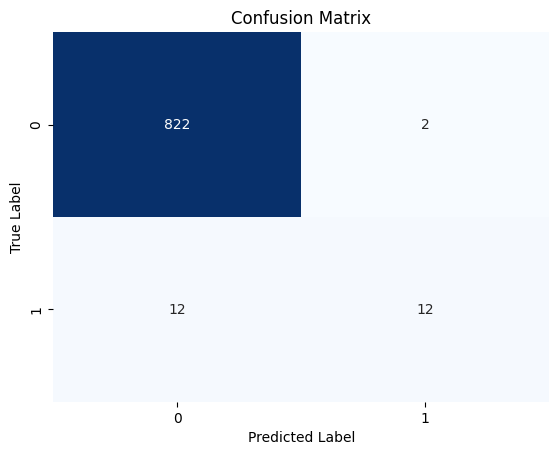

In [9]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

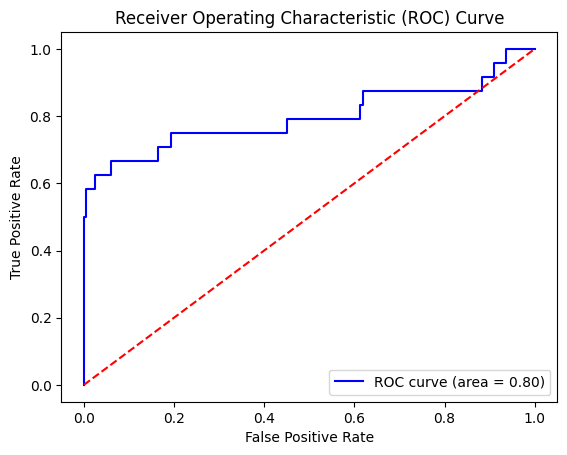

In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Model Accuracy: 0.9846698113207547


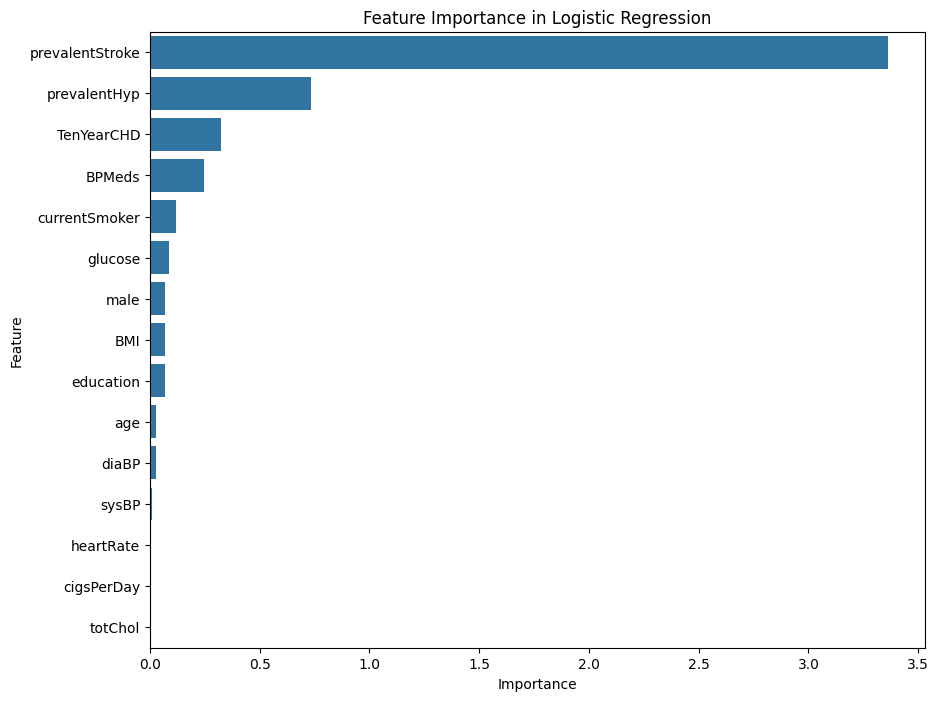

In [11]:
# Hyperparameter Tuning with Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization type
    'solver': ['liblinear']         # Suitable for small datasets and L1 regularization
}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and performance after tuning
best_log_reg = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the tuned model
y_pred_tuned = best_log_reg.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Tuned Model Accuracy:", accuracy_tuned)

# Feature Importance Analysis
feature_importance = best_log_reg.coef_[0]
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_df['Importance'] = np.abs(feature_df['Importance'])
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance in Logistic Regression")
plt.show()
